# Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do you best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard) (but don't start learning about it now, it takes a while to get it up and running).




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from astroML.utils import split_samples, completeness_contamination
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import corner

2023-03-06 05:54:22.794651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 05:54:22.971283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 05:54:22.971334: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-06 05:54:23.938012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Collect the data


In [2]:
u=[]
g=[]
r=[]
i=[]
z=[]
clas=[]
z1=[]
zerr=[]

with open('solutions/galaxyquasar.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        u.append(float(row["u"]))
        g.append(float(row["g"]))
        r.append(float(row["r"]))
        i.append(float(row["i"]))
        z.append(float(row["z"]))
        clas.append((row["class"]))
        z1.append(float(row["z1"]))
        zerr.append(float(row["zerr"]))
        #print(f'\t{row["u"]} , {row["g"]} , {row["r"]} , {row["i"]} , {row["z"]} , {row["class"]} , {row["z1"]} , {row["zerr"]}')
        line_count += 1
    print(f'Processed {line_count} lines.')
    
labels=[]

for label in clas:
    if label=='QSO':
        labels.append(1)
    else:
        labels.append(0)

u = np.array(u)
g = np.array(g)
r = np.array(r)
i = np.array(i)
z = np.array(z)
clas = np.array(clas)
z1 = np.array(z1)
zerr = np.array(zerr)
labels = np.array(labels)

        
u_g = u - g
g_r = g - r
r_i = r - i
i_z = i - z

Column names are u, g, r, i, z, class, z1, zerr
Processed 50001 lines.


Define sklearn variables

In [3]:
X=np.array([u_g,g_r,r_i,i_z]).T
y = labels

d = {'ug': u_g, 'gr': g_r,'ri': r_i, 'iz':i_z}     

Plot the colors. The u_g is the best candidate to classify QSO, and it is visible also a bimodality

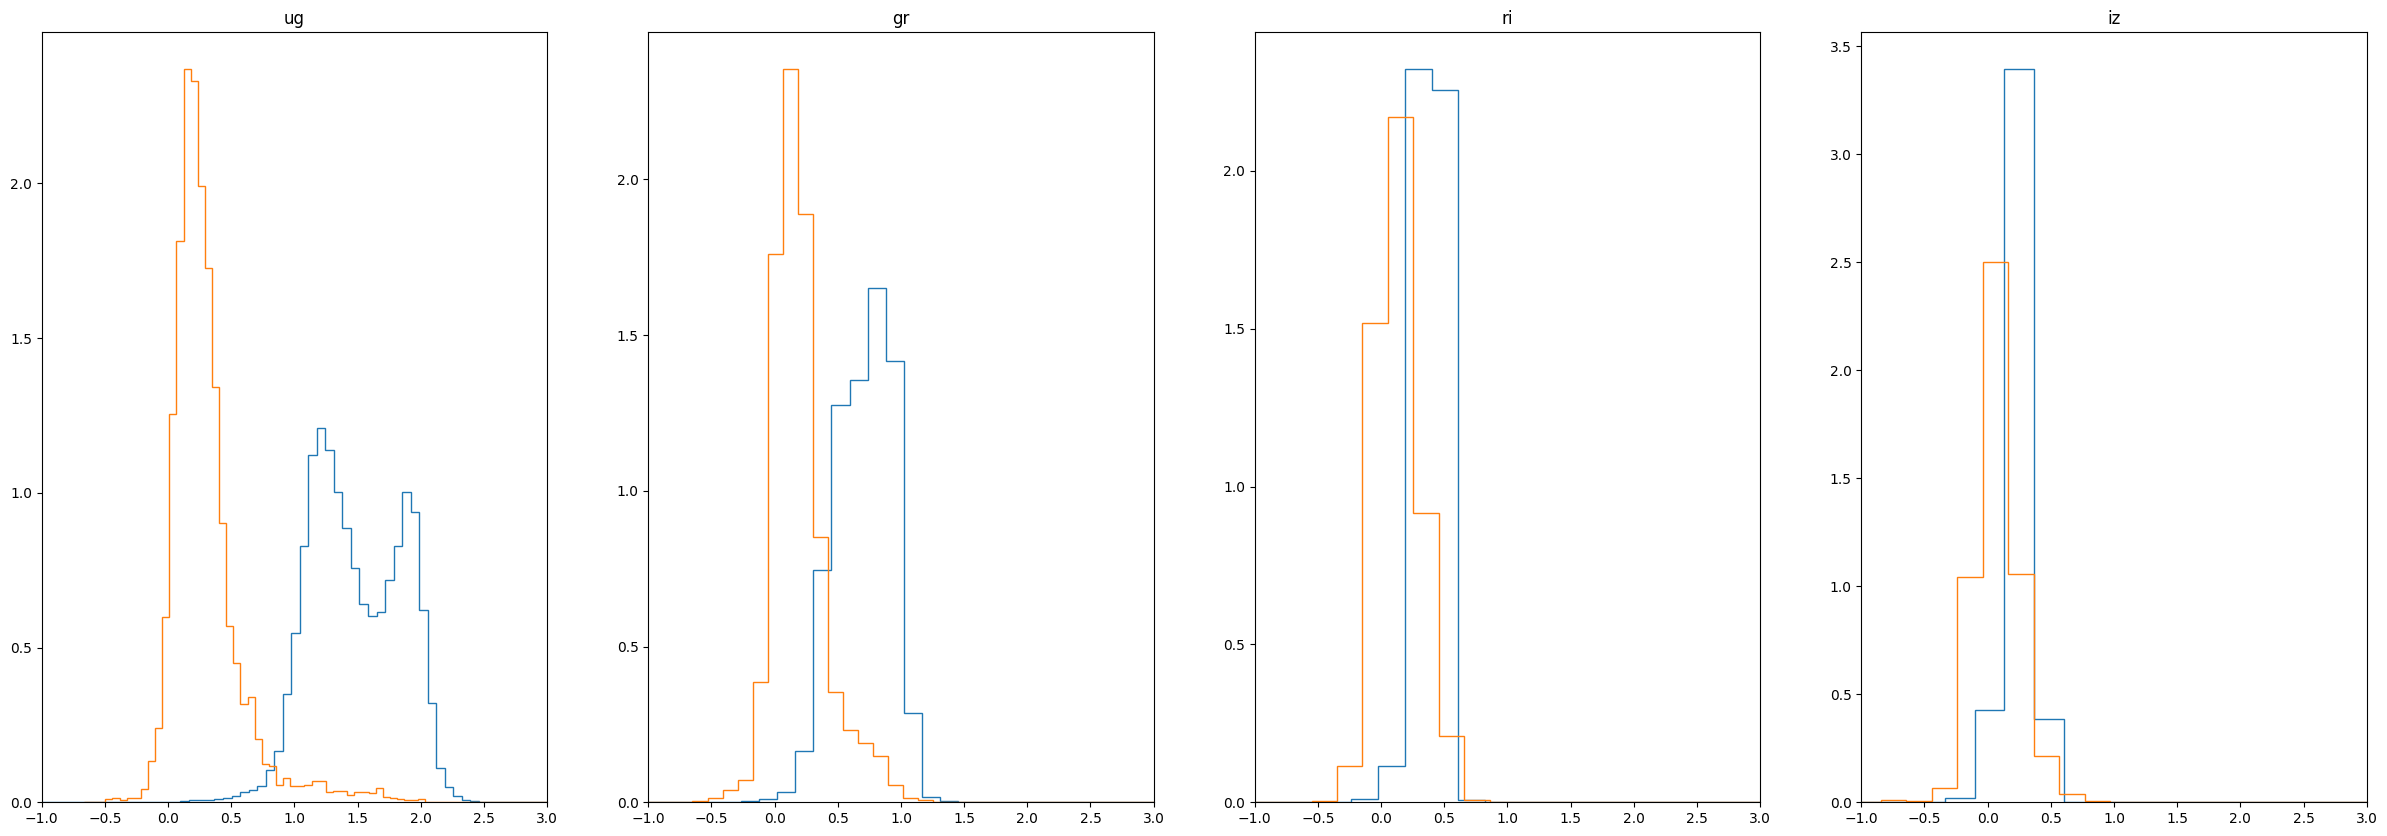

In [4]:
i=0
plt.figure(figsize=(30,10))
for l in d.keys():
    i+=1
    plt.subplot(1,4,i)
    plt.hist(d[l][labels==0],bins=100,density=True, histtype='step')
    plt.hist(d[l][labels==1],bins=100,density=True, histtype='step')
    plt.xlim(-1,3)
    plt.title(l)
    
    

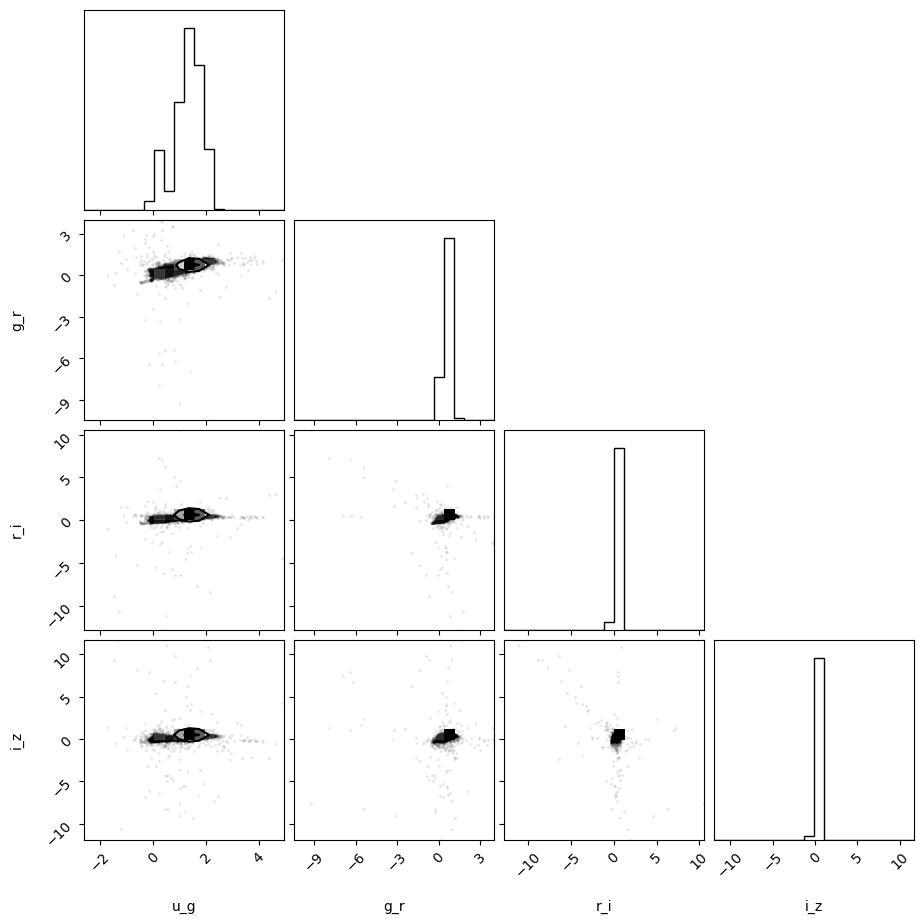

In [5]:
fig=corner.corner(X,labels=['u_g','g_r','r_i','i_z'])

Split the data in training and test sets

In [6]:
(X_train_full, X_test), (y_train_full, y_test) = split_samples(X, y, [0.70, 0.30], random_state=0)

Let me start with a sklearn implementation of an ANN. Selected the hyperparams I obtain a good perfromance as shown by the ROC curve.

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(0.0, 0.1)

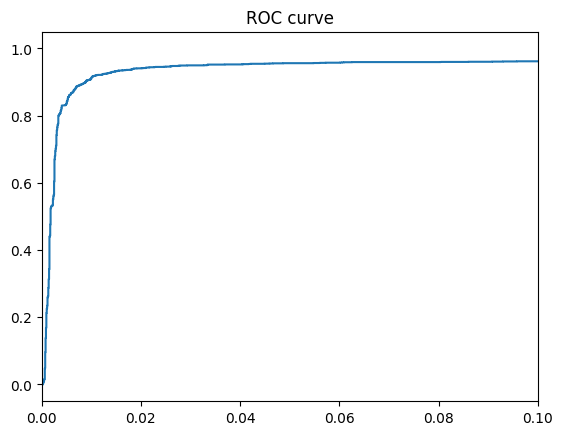

In [7]:

clf = MLPClassifier(
    hidden_layer_sizes=(5), 
    activation='relu',
    solver='adam',
    alpha=0,
    learning_rate_init=0.001,
    max_iter=200)



clf.fit(X_train_full[:1000], y_train_full[:1000])
y_prob=clf.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlim(0,0.1)

GridSearchCV helps me to determine the best params for the classifier

In [8]:
HLrange = np.arange(1,15, 30) # Test 30 bandwidths from 0.1 to 1.0
LRrange = np.linspace(1e-3,1e-1,30)
MIrange = np.linspace(0,1000,30)
Arange = np.linspace(1e-2,0,30)

#params_dict = {'hidden_layer_sizes': HLrange, 'learning_rate_init' : LRrange, 'max_iter': MIrange, 'alpha' : Arange}
params_dict = {'hidden_layer_sizes': HLrange, 'alpha' : Arange}

K = 5 # Do 5-fold cross validation
grid = GridSearchCV(MLPClassifier(), params_dict, cv= K) # Try each bandwidth with K-folds
grid.fit(X_train_full[:1000], y_train_full[:1000]) #Fit the histogram data that we started the lecture with.

print(grid.best_params_['hidden_layer_sizes'])
print(grid.best_params_['alpha'])

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn'

1
0.002068965517241379


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Improved the model I plot the rpediction in comparison with the true labels

(0.9, 1.0)

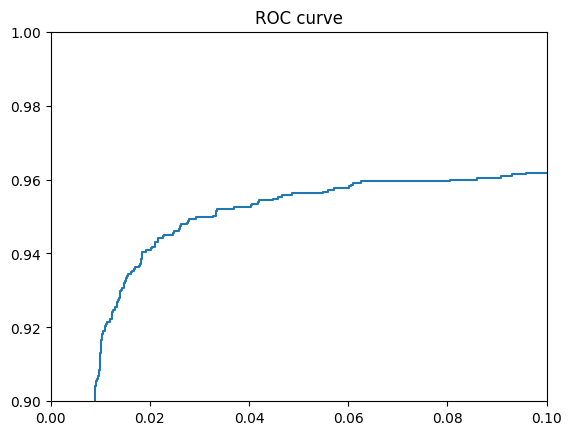

In [9]:
bestclf = MLPClassifier(
    hidden_layer_sizes=(1), 
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.002,
    max_iter=200)

bestclf.fit(X_train_full[:1000], y_train_full[:1000])
y_prob=clf.predict_proba(X_test)[:,1]
y_pred=bestclf.predict(X)
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlim(0,0.1)
plt.ylim(0.9,1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


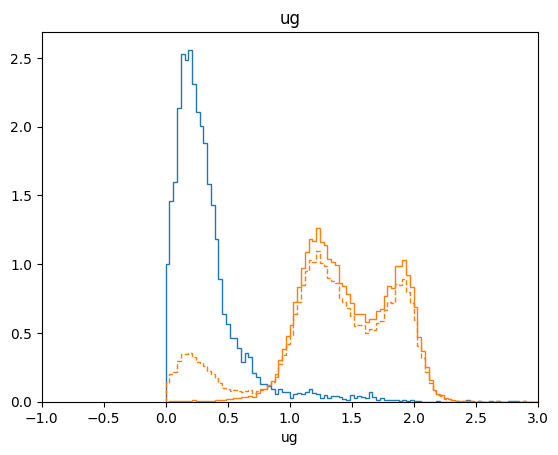

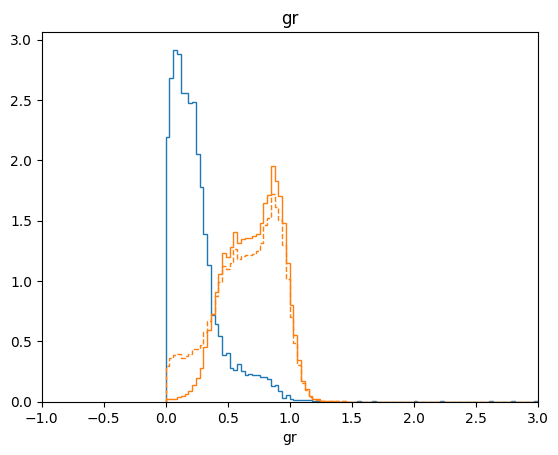

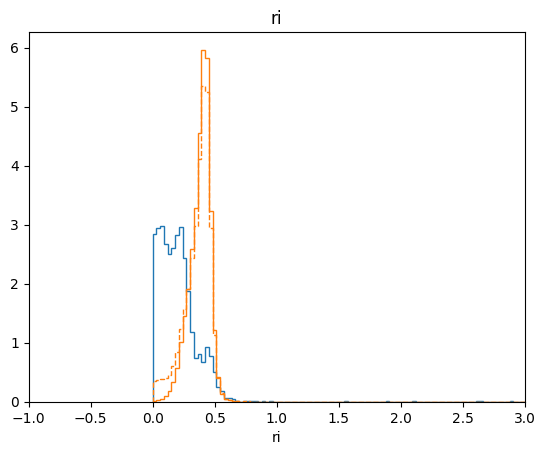

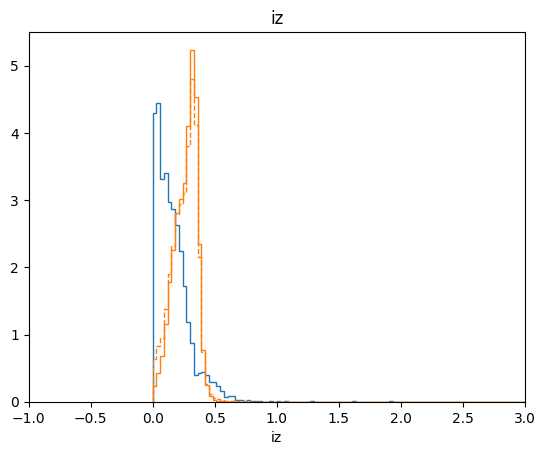

In [10]:
for col in d.keys():

    plt.hist(d[col][y==1],histtype='step',bins=np.linspace(0,3,100),density=True,color='C0')
    plt.hist(d[col][y==0],histtype='step',bins=np.linspace(0,3,100),density=True,color='C1')

    plt.hist(d[col][y_pred==1],histtype='step',bins=np.linspace(0,3,100),density=True,color='C0',ls='dashed')
    plt.hist(d[col][y_pred==0],histtype='step',bins=np.linspace(0,3,100),density=True,color='C1',ls='dashed')
    plt.title(col)
    plt.xlim(-1,3)
    plt.xlabel(col)
    plt.show()

Let me try a CNN.

In [11]:
keras.backend.clear_session() # Make sure that we are starting a new model and not adding to an earlier one
np.random.seed(42) # Set the numpy and tensorflow random seeds so that we all get the same answer
tf.random.set_seed(42)

# Fill the validation, training and test sets
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Let me normalize to zero mean and unit variance for easier training
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


# Need to reshape for CNN
X_train = X_train[:, :, np.newaxis, np.newaxis]
X_valid = X_valid[:, :, np.newaxis, np.newaxis]
X_test = X_test[:, :, np.newaxis, np.newaxis]

print(len(X_train))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)



# Now I define a series of layers
# input layer (X_trian_shape)
# 64 kernels of size 7x7 few synapses
# activation function is relu (= quicker)

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[4,1,1]), 
    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(pool_size=1),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
    keras.layers.MaxPooling2D(pool_size=1),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=1),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=2, activation='sigmoid'), #sigmoid -> binary classification softmax multylabels
])  

print(model.summary()) 

30000
(30000, 4, 1, 1)
(5000, 4, 1, 1)
(15000, 4, 1, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 1, 64)          3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 1, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 1, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 1, 128)         147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 1, 128)        0         
 2D)                                                             
                                                                 


2023-03-06 05:55:17.648967: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 05:55:17.649036: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 05:55:17.649083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-dgerosa-2dastrost-2dcs-5fbicocca-5f2022-2dingigb3d): /proc/driver/nvidia/version does not exist
2023-03-06 05:55:17.649500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,249,474
Trainable params: 1,249,474
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# This may take a while! Hopefully no more than 5 minutes for 1 epoch.
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-2), metrics=["accuracy"])
clf = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))




938/938 [==============================] - 133s 141ms/step - loss: 0.1921 - accuracy: 0.9673 - val_loss: 0.1252 - val_accuracy: 0.9802


In [13]:
# Evaluate the test set
model.evaluate(X_test, y_test)




469/469 [==============================] - 8s 18ms/step - loss: 0.1044 - accuracy: 0.9775


[0.10444533079862595, 0.9775333404541016]

469/469 [==============================] - 8s 17ms/step
(15000,)
completness 0.9092601209865053
contamination 0.06774809160305344


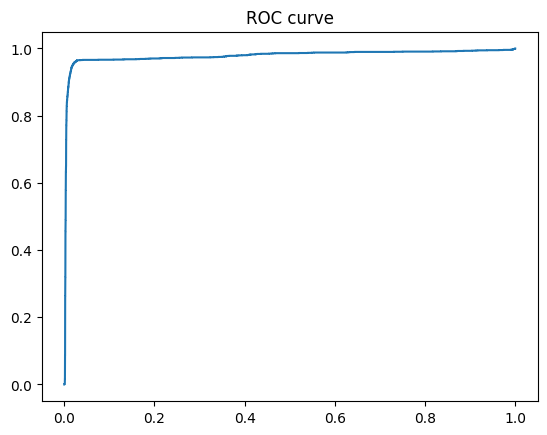

In [14]:
# let me compute the predicitons and the probability and compute the roc curve 

y_proba_full = model.predict(X_test)[:,1]
y_pred_full_test = np.argmax(model.predict(X_test), axis=-1)
print(y_proba_full.shape)

fpr, tpr, threshold = roc_curve(y_test, y_proba_full, pos_label=1)

completeness, contamination = completeness_contamination(y_pred_full_test, y_test)

plt.figure()

plt.plot(fpr,tpr)
plt.title('ROC curve')
print('completness',completeness)
print('contamination',contamination)



938/938 [==============================] - 16s 17ms/step
(30000,)
completness 0.9069821930646673
contamination 0.0679027209246328


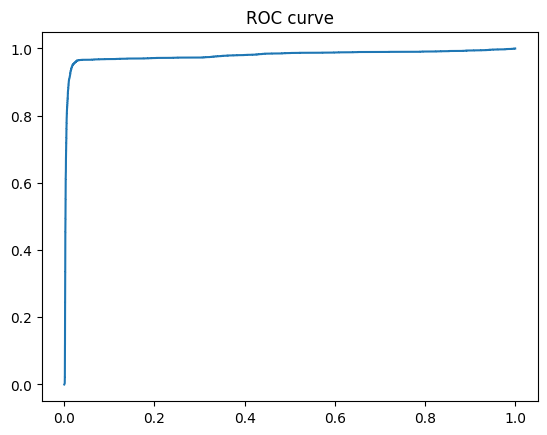

In [15]:
y_proba_full = model.predict(X_train)[:,1]
y_pred_full_test = np.argmax(model.predict(X_train), axis=-1)
print(y_proba_full.shape)

fpr, tpr, threshold = roc_curve(y_train, y_proba_full, pos_label=1)

completeness, contamination = completeness_contamination(y_pred_full_test, y_train)

plt.figure()

plt.plot(fpr,tpr)
plt.title('ROC curve')
print('completness',completeness)
print('contamination',contamination)

(array([5.87439476e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.87439476e-04, 0.00000000e+00, 5.87439476e-04,
        1.17487895e-03, 0.00000000e+00, 5.87439476e-04, 0.00000000e+00,
        5.87439476e-04, 1.17487895e-03, 5.87439476e-04, 5.87439476e-04,
        1.17487895e-03, 1.76231843e-03, 1.17487895e-03, 2.34975790e-03,
        1.17487895e-03, 1.17487895e-03, 5.87439476e-04, 5.87439476e-04,
        1.17487895e-03, 1.17487895e-03, 5.87439476e-04, 0.00000000e+00,
        1.17487895e-03, 1.76231843e-03, 1.76231843e-03, 1.17487895e-03,
        1.76231843e-03, 1.17487895e-03, 0.00000000e+00, 2.34975790e-03,
        4.11207633e-03, 2.34975790e-03, 5.28695528e-03, 8.22415266e-03,
        1.29236685e-02, 1.52734264e-02, 1.87980632e-02, 1.58608659e-02,
        3.05468527e-02, 4.75825976e-02, 9.75149530e-02, 2.22639561e-01,
        4.09445315e-01, 5.05785389e-01, 7.16676161e-01, 8.74697380e-01,
        1.06444033e+00, 1.19661421e+00, 1.23773498e+00, 1.233035

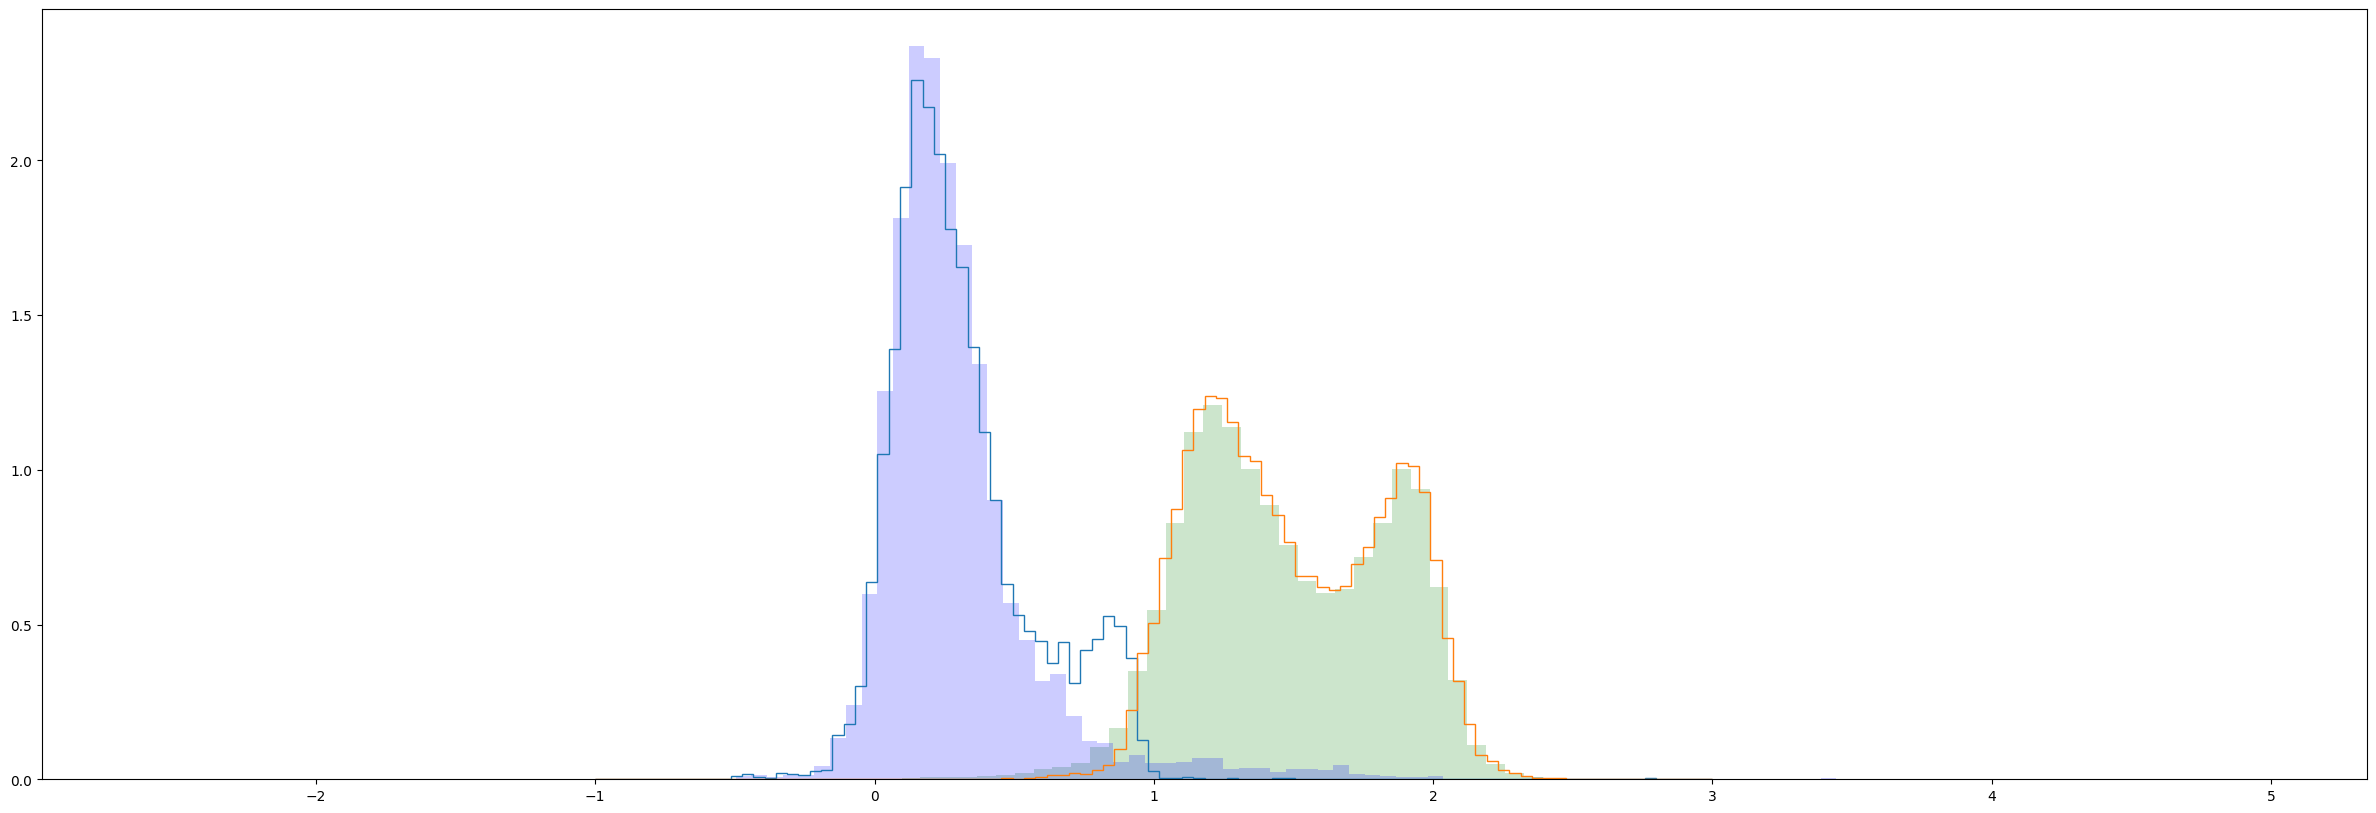

In [66]:
# plot predictions

X=np.array([u_g,g_r,r_i,i_z]).T
X=X[:, :, np.newaxis, np.newaxis]
y_proba_full = model.predict(X)[:,1]
y_pred = np.where(y_proba_full>0.2 ,0,1)

#y_pred_full = (model.predict(X)[:,1] > 0.5).astype('int32') #np.argmax(model.predict(X), axis=-1)

plt.figure(figsize=(30,10))
plt.hist(u_g[y==0],density=True, histtype='stepfilled',alpha=0.2, bins=100, color='green')
plt.hist(u_g[y==1],density=True, histtype='stepfilled',alpha=0.2, bins=100,color='blue')
#plt.hist(u_g[y_pred_full==0],density=True, histtype='step', bins=100, color='yellow')
#plt.hist(u_g[y_pred_full==1],density=True, histtype='step', bins=100,color='C0') #QSO
plt.hist(u_g[y_pred==1], bins=np.linspace(-1,3,100),density=True,histtype='step')
plt.hist(u_g[y_pred==0], bins=np.linspace(-1,3,100), density=True,histtype='step')